<a href="https://colab.research.google.com/github/Okra77/LearningFromData/blob/main/Wine3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

In [65]:
EPOCHS=100 # 總訓練次數
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 設定訓練裝置，如果有GPU就用GPU，沒有就用CPU

In [66]:
# 載入Wine數據集
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',sep=';',header=0)
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [67]:
data['quality'].value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

In [68]:
X = data.drop('quality',axis=1)
y = data['quality']
y = y.apply(lambda x: 0 if x<=5 else 1)
y.value_counts()

1    3258
0    1640
Name: quality, dtype: int64

In [69]:
#balance data
X = X[y==0].append(X[y==1].sample(1640,random_state=0))
X
X.count

<bound method DataFrame.count of       fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
10              8.1              0.27         0.41            1.45      0.033   
11              8.6              0.23         0.40            4.20      0.035   
12              7.9              0.18         0.37            1.20      0.040   
14              8.3              0.42         0.62           19.25      0.040   
19              6.5              0.31         0.14            7.50      0.044   
...             ...               ...          ...             ...        ...   
3283            6.6              0.20         0.14            4.40      0.184   
4138            6.6              0.23         0.32            1.50      0.041   
1820            6.8              0.30         0.35            2.80      0.038   
3478            6.2              0.36         0.45           10.40      0.060   
2029            7.6              0.34         0.39            7.60      0.04

In [70]:
y = y[y==0].append(y[y==1].sample(1640,random_state=0))
y.value_counts()

0    1640
1    1640
Name: quality, dtype: int64

In [71]:
y

10      0
11      0
12      0
14      0
19      0
       ..
3283    1
4138    1
1820    1
3478    1
2029    1
Name: quality, Length: 3280, dtype: int64

In [72]:
#one hot encoding
y = pd.get_dummies(y)


mms = MinMaxScaler()
X = mms.fit_transform(X)
y

,0,1
10,1,0
11,1,0
12,1,0
14,1,0
19,1,0
...,...,...
3283,0,1
4138,0,1
1820,0,1
3478,0,1


In [73]:
X

array([[0.40776699, 0.18627451, 0.24698795, ..., 0.24770642, 0.39534884,
        0.64516129],
       [0.45631068, 0.14705882, 0.24096386, ..., 0.3853211 , 0.36046512,
        0.27419355],
       [0.38834951, 0.09803922, 0.22289157, ..., 0.42201835, 0.47674419,
        0.4516129 ],
       ...,
       [0.2815534 , 0.21568627, 0.21084337, ..., 0.33944954, 0.36046512,
        0.64516129],
       [0.22330097, 0.2745098 , 0.27108434, ..., 0.5412844 , 0.39534884,
        0.29032258],
       [0.3592233 , 0.25490196, 0.23493976, ..., 0.35779817, 0.36046512,
        0.19354839]])

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 轉換成PyTorch的Tensor
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train.values).float()
y_test = torch.from_numpy(y_test.values).float()

In [75]:
X_train.shape , y_train.shape

(torch.Size([2624, 11]), torch.Size([2624, 2]))

In [76]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, y_train.shape[1])
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

In [77]:
class data_loader(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [78]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target.argmax(1))
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [79]:
def test(model,device,optimizer,epoch,test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target.argmax(1), reduction='sum').item()  # sum up batch loss
            pred = output.argmax(1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.argmax(1, keepdim=True).view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, (100. * correct / len(test_loader.dataset))

In [80]:
train_loader = data_loader(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_loader, batch_size=12, shuffle=True)
test_loader = data_loader(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_loader, batch_size=12, shuffle=True)

In [81]:
model = Net().to(DEVICE)
opt = optim.Adam(model.parameters(), lr=0.001)
acc_list = list()
avg_loss_list = list()
for epoch in range(1, EPOCHS + 1):
    train(model, DEVICE, train_loader, opt, epoch)
    acc , avg_loss = test(model, DEVICE, opt, epoch, test_loader)
    acc_list.append(acc)
    avg_loss_list.append(avg_loss)

Train Epoch: 1 [0/2624 (0%)]	Loss: 0.700193
Train Epoch: 1 [1200/2624 (46%)]	Loss: 0.662966
Train Epoch: 1 [2400/2624 (91%)]	Loss: 0.878770
Test set: Average loss: 0.5527, Accuracy: 476/656 (73%)
Train Epoch: 2 [0/2624 (0%)]	Loss: 0.648216
Train Epoch: 2 [1200/2624 (46%)]	Loss: 0.527810
Train Epoch: 2 [2400/2624 (91%)]	Loss: 0.537927
Test set: Average loss: 0.5500, Accuracy: 464/656 (71%)
Train Epoch: 3 [0/2624 (0%)]	Loss: 0.484609
Train Epoch: 3 [1200/2624 (46%)]	Loss: 0.396288
Train Epoch: 3 [2400/2624 (91%)]	Loss: 0.452213
Test set: Average loss: 0.5481, Accuracy: 464/656 (71%)
Train Epoch: 4 [0/2624 (0%)]	Loss: 0.555271
Train Epoch: 4 [1200/2624 (46%)]	Loss: 0.879784
Train Epoch: 4 [2400/2624 (91%)]	Loss: 0.458043
Test set: Average loss: 0.5393, Accuracy: 473/656 (72%)
Train Epoch: 5 [0/2624 (0%)]	Loss: 0.605453
Train Epoch: 5 [1200/2624 (46%)]	Loss: 0.635394
Train Epoch: 5 [2400/2624 (91%)]	Loss: 0.304503
Test set: Average loss: 0.5448, Accuracy: 482/656 (73%)
Train Epoch: 6 [0/26

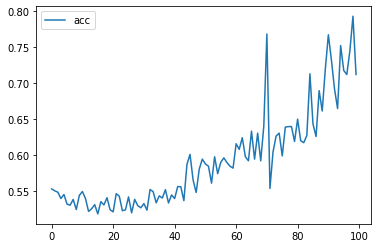

In [82]:
plt.plot(acc_list, label='acc')
plt.legend()
plt.show()

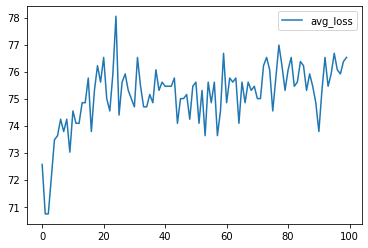

In [83]:
plt.plot(avg_loss_list, label='avg_loss')
plt.legend()
plt.show()

In [84]:
model.eval()
with torch.no_grad():
    output = model(X_test[3].to(DEVICE))
    pred = output
    print(pred)
    print(y_test[3])

tensor([ 1.1008, -1.0835])
tensor([1., 0.])
